# Physics-informed DeepONet: Solving a ODE for different right hand sides
In this notebook, we present an introduction to the physics-informed DeepONet [(paper)](https://arxiv.org/abs/2103.10974) utilities of TorchPhysics. 
As an example, we try to learn the integral operator of the ODE:
\begin{align*}
    \partial_t u(t) &= f(t), \text{ in } [0, 1] \\
    u(0) &= 0
\end{align*}
for different functions $f$. 

The general structure of TorchPhysics still holds for DeepONet problems. But we need some new concepts to define training functions of $f$. Here we show, how to:

- create a function space for different training functions
- define a DeepONet-neural-network consisting of trunk and branch net

and some additional details one has to consider.


In [1]:
import torch
import torchphysics as tp
import pytorch_lightning as pl
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
# Spaces 
T = tp.spaces.R1('t') # input variable
U = tp.spaces.R1('u') # output variable
K = tp.spaces.R1('k') # parameter
F = tp.spaces.R1('f') # function output space name
# Domains
T_int = tp.domains.Interval(T, 0, 1)
K_int = tp.domains.Interval(K, 0, 6) # Parameters will be scalar values

In [3]:
# Defining function set
Fn_space = tp.spaces.FunctionSpace(T_int, F)

def f1(k, t):
    return k*t

def f2(k, t):
    return k*t**2

def f3(k, t):
    return k*torch.cos(k*t)

param_sampler = tp.samplers.RandomUniformSampler(K_int, n_points=40)
Fn_set = tp.domains.CustomFunctionSet(Fn_space, param_sampler, f1)
Fn_set += tp.domains.CustomFunctionSet(Fn_space, param_sampler, f2)
Fn_set += tp.domains.CustomFunctionSet(Fn_space, param_sampler, f3)

In [4]:
# Model
dis_sampler = tp.samplers.GridSampler(T_int, 50).make_static()
trunk_net = tp.models.FCTrunkNet(T, U, hidden=(30, 30), output_neurons=50)
branch_net = tp.models.FCBranchNet(Fn_space, U, output_neurons=50, 
                                   hidden=(50, 50), 
                                   discretization_sampler=dis_sampler)
model = tp.models.DeepONet(trunk_net, branch_net)

In [5]:
# ODE condition
inner_sampler = tp.samplers.RandomUniformSampler(T_int, 1000)

def ode_residual(u, t, f):
    return tp.utils.grad(u, t) - f

ode_cond = tp.conditions.PIDeepONetCondition(deeponet_model=model, 
                                             function_set=Fn_set, 
                                             input_sampler=inner_sampler, 
                                             name='ode_condition',
                                             residual_fn=ode_residual)

In [6]:
left_sampler = tp.samplers.RandomUniformSampler(T_int.boundary_left, 500)

def initial_residual(u):
    return u

initial_cond = tp.conditions.PIDeepONetCondition(deeponet_model=model, 
                                                 function_set=Fn_set, 
                                                 input_sampler=left_sampler, 
                                                 residual_fn=initial_residual)

In [7]:
solver = tp.solver.Solver([ode_cond, initial_cond])

trainer = pl.Trainer(gpus='-1' if torch.cuda.is_available() else None,
                     num_sanity_val_steps=0,
                     benchmark=True,
                     max_steps=4000,
                     logger=False,
                     checkpoint_callback=False
                     )

trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [2]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 10.2 K
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
10.2 K    Trainable params
0         Non-trainable params
10.2 K    Total params
0.041     Total estimated model params size (MB)
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarnin

Training: 0it [00:00, ?it/s]

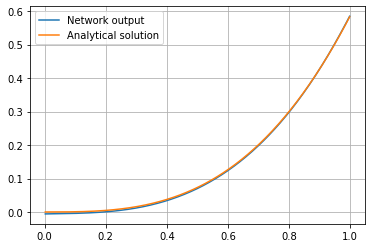

In [ ]:
import matplotlib.pyplot as plt

k0 = 1.76
def f(t):
    return k0 * t**2

def F(t):
    return k0/3.0 * t**3

model.fix_branch_input(f)
grid_sampler = tp.samplers.GridSampler(T_int, 500)
grid_points = grid_sampler.sample_points()
out = model(grid_points).as_tensor.detach()[0]

grid_p = grid_points.as_tensor
plt.plot(grid_p, out)
plt.plot(grid_p, F(grid_p))
plt.grid()
plt.legend(['Network output', 'Analytical solution'])

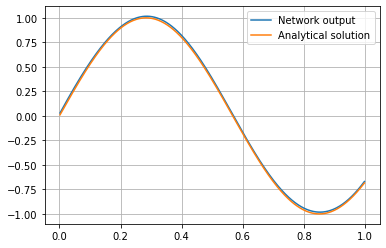

In [ ]:
k0 = 5.54
def f(t):
    return k0 * torch.cos(k0*t)

def F(t):
    return torch.sin(k0*t)

model.fix_branch_input(f)
grid_sampler = tp.samplers.GridSampler(T_int, 500)
grid_points = grid_sampler.sample_points()
out = model(grid_points).as_tensor.detach()[0]

grid_p = grid_points.as_tensor
plt.plot(grid_p, out)
plt.plot(grid_p, F(grid_p))
plt.grid()
plt.legend(['Network output', 'Analytical solution'])